https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *
from preprocessing.Sets import Sets
from utility.ML import ML

In [2]:
########### switches ################################

saveName='Oct19-2018_3'
saveFolder = saveName
saveplots=False
createSubmit = False
SelfValidate = False
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"

############# Options/Args #########################

verbose=True
lag_length = 1
diff = False
diffRel = False 
addPriceRange = True

target = 'shop_item_cnt_month'
# target = 'shop_item_cnt_month_diff(0-1)'

#these columns will be dropped in createTrain/Val/Test --> Depracated
col_targets=[]

####### mean Encode (with Reg) #####

meanEncode=True #this is just necessary condition for mean encoding. but need to turn on individual switches below to include columsn of target encoding.
meanEncodeCol=[ #this is for lag features.
             'shop',
             'item',
             'item_cat',
            ]

agg_targ = {'item_cnt_day':'sum'} #target_encoding!
# agg_targ = {'item_cnt_day':'mean'} #target_encoding!

Regularize = True
enc_cnt_per_shop = True
enc_cnt_per_item = True
enc_cnt_per_item_cat = True
enc_priceRange = True

targEnc_to_Reg = {}
NaN_targEnc = {}

if(enc_cnt_per_shop):targEnc_to_Reg.update({'shop_id':'shop'})
if(enc_cnt_per_item):targEnc_to_Reg.update({'item_id':'item'})
if(enc_cnt_per_item_cat):targEnc_to_Reg.update({'item_category_id':'item_cat'})
if(enc_priceRange):targEnc_to_Reg.update({'price_range':'price_range'})

if(enc_cnt_per_shop):NaN_targEnc.update({'shop':-999})
if(enc_cnt_per_item):NaN_targEnc.update({'item':-999})
if(enc_cnt_per_item_cat):NaN_targEnc.update({'item_cat':-999})
if(enc_priceRange):NaN_targEnc.update({'price_range':-999})

####################################

#columns to keep
col_to_keep = [
                'shop_id',
                'item_id',
                #'item_price',
                'item_category_id',
                'item_cnt_day',
                ]

groupby_list = ['shop_id','item_id']

agg_dict = {
            #'item_price':'mean',
            'item_category_id':'mean',
            'item_cnt_day':'sum',
            }

    
opt = {
        'verbose':verbose,
        'lag_length':lag_length,
        'diff':diff,
        'diffRel':diffRel,
        'target':target,
        'col_to_keep':col_to_keep,
        'groupby_list':groupby_list,
        'agg_dict':agg_dict,
        'agg_targ':agg_targ,
        'col_targets':col_targets,
        'meanEncode':meanEncode,
        'meanEncodeCol':meanEncodeCol,
        'targEnc_to_Reg':targEnc_to_Reg,
        'NaN_targEnc':NaN_targEnc,
        } 


#clipTarget = True
lowerClip = 0
upperClip = 20
if target=='shop_item_cnt_month_diff(0-1)':
    lowerClip = -20
    upperClip = 20    

########################################################

In [3]:
#del Sets
Sets = Sets(**opt)

dup_ids = Sets.checkDuplicates()
Sets.convertDatetime()
Sets.translateItemCategoryId()
Sets.addItemCategoryId()
Sets.addTranslatedItemCategoryId()
Sets.addYMcolumn()
bin_edges=[0,10,100,200,500,1000,2500,5000,20000,999999]
Sets.binPrice(bin_edges)
Sets.splitDataByYear()
data = Sets.getData()


sales_train shape: (2935849, 6)

lag_length: 1
diff: False
diffRel: False
target: shop_item_cnt_month

target encoding: {'item_cnt_day': 'sum'}


Checking for duplicates in sales_train

Found 6 duplicates in sales_train : [  76962 1435367 1496766 1671873 1866340 2198566]
Kept first, removed duplicates

Checking for duplicates in test
Found no duplicates in test

Format 'date' to 'datetime' in sales_train

Add new column: 'item_category_id' to sales_train

Add new column: 'english translated item_category_id' to sales_train

Add new column: years, month, Y_M to sales_train

Counting based on the defined bins:

0-10 : 36050
10-100 : 121831
100-200 : 501713
200-500 : 1013478
500-1000 : 596653
1000-2500 : 464971
2500-5000 : 167315
5000-20000 : 27050
20000-999999 : 6781
999999-: 0
bins: [(0, 10), (10, 100), (100, 200), (200, 500), (500, 1000), (1000, 2500), (2500, 5000), (5000, 20000), (20000, 999999)]
labels: ['0to10', '10to100', '100to200', '200to500', '500to1000', '1000to2500', '2500to5

In [4]:
for i in data:print i

sales_2013
sales_2014
sales_2015
items
test
sales_train
shops
item_categories


In [5]:
data['items'].head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
data['item_categories'].head()

,item_category_name,item_category_id,eng_cat_id
0,PC - Гарнитуры/Наушники,0,Access
1,Аксессуары - PS2,1,Access
2,Аксессуары - PS3,2,Access
3,Аксессуары - PS4,3,Access
4,Аксессуары - PSP,4,Access


In [7]:
data['sales_train'].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,eng_cat_id,year,month,Y_M,price_range
0,2013-01-02,0,59,22154,999.00,1.0,37,Movie,2013,1,2013_1,"(500, 1000]"
1,2013-01-03,0,25,2552,899.00,1.0,58,Music,2013,1,2013_1,"(500, 1000]"
2,2013-01-05,0,25,2552,899.00,-1.0,58,Music,2013,1,2013_1,"(500, 1000]"
3,2013-01-06,0,25,2554,1709.05,1.0,58,Music,2013,1,2013_1,"(1000, 2500]"
4,2013-01-15,0,25,2555,1099.00,1.0,56,Music,2013,1,2013_1,"(1000, 2500]"


In [8]:
train = data['sales_train']

In [9]:
#by item cnt 
item_cnt = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_cnt_day',aggfunc='sum')
item_cnt.fillna(0.0,inplace=True)
item_cnt = item_cnt.reset_index()
item_cnt = item_cnt.rename_axis("", axis="columns") #removes "date_block_num" as index name.
print item_cnt.shape
item_cnt.head()


(424124, 36)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#by item price
item_price = train.pivot_table(index=['shop_id','item_id'],columns=['date_block_num'],values='item_price',aggfunc='min')
item_price.fillna(0.0,inplace=True)
item_price = item_price.reset_index()
item_price = item_price.rename_axis(" ", axis="columns") #removes "date_block_num" as index name.
print item_price.shape
item_price.head()

(424124, 36)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,0.0,434.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,221.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,347.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,247.0,247.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Add item category id
item_id = data['items'][['item_id','item_category_id']]
item_cat = data['item_categories'][['item_category_id','eng_cat_id']]

In [12]:
print item_id.shape
item_id.head()

(22170, 2)


,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [13]:
print item_cat.shape
item_cat.head()

(84, 2)


,item_category_id,eng_cat_id
0,0,Access
1,1,Access
2,2,Access
3,3,Access
4,4,Access


In [14]:
df =  pd.merge(item_cnt,item_id,on='item_id',how='left')
print df.shape
df.head()

(424124, 37)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,item_category_id
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


In [15]:
df =  pd.merge(df,item_cat,on='item_category_id',how='left')
print df.shape
df.head()

(424124, 38)


,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,eng_cat_id
0,0,30,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
1,0,31,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
2,0,32,6.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie
3,0,33,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
4,0,35,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,Movie


In [16]:
df.tail()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,item_category_id,eng_cat_id
424119,59,22154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
424120,59,22155,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,Movie
424121,59,22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40,Movie
424122,59,22164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,37,Movie
424123,59,22167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,Books


In [17]:
df = df[['shop_id', 'item_id','item_category_id', 'eng_cat_id'] + list(range(34))]
print df.shape
df.head()

(424124, 38)


,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,Movie,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,Movie,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,Movie,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,Movie,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,Movie,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Label encode categories
from sklearn import preprocessing
number = preprocessing.LabelEncoder()
df[['eng_cat_id']] = number.fit_transform(df.eng_cat_id)
df.head()

,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,7,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create train/val/test set

In [19]:
block_to_select = 10
block_end = block_to_select+1
lenght_of_lag = 5
start_of_lag_cols = 4
begin_col = start_of_lag_cols+block_end-lenght_of_lag-1
end_col = start_of_lag_cols+block_end


x_train = pd.concat([df.iloc[:,:start_of_lag_cols],df.iloc[:,begin_col:end_col]],axis=1)
y_train = df[block_to_select]
print x_train.shape
x_train.head()

(424124, 10)


,shop_id,item_id,item_category_id,eng_cat_id,5,6,7,8,9,10
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#rename and drop target
new_col_names = ['item_cnt_lag_{}'.format(i) for i in range(lenght_of_lag,-1,-1)]
d = dict(zip(x_train.columns[start_of_lag_cols:],new_col_names))
x_train  = x_train.rename(d, axis = 1)
x_train  = x_train.drop(columns='item_cnt_lag_0')

x_train.head()

,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0


In [21]:
block_to_select = 22
block_end = block_to_select+1
lenght_of_lag = 5
start_of_lag_cols = 4
begin_col = start_of_lag_cols+block_end-lenght_of_lag-1
end_col = start_of_lag_cols+block_end

x_val = pd.concat([df.iloc[:,:start_of_lag_cols],df.iloc[:,begin_col:end_col]],axis=1)
y_val = df[block_to_select]
print x_val.shape
x_val.head()

(424124, 10)


,shop_id,item_id,item_category_id,eng_cat_id,17,18,19,20,21,22
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#rename and drop target
new_col_names = ['item_cnt_lag_{}'.format(i) for i in range(lenght_of_lag,-1,-1)]
d = dict(zip(x_val.columns[start_of_lag_cols:],new_col_names))
x_val  = x_val.rename(d, axis = 1)
x_val  = x_val.drop(columns='item_cnt_lag_0')
x_val.head()

,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1
0,0,30,40,7,0.0,0.0,0.0,0.0,0.0
1,0,31,37,7,0.0,0.0,0.0,0.0,0.0
2,0,32,40,7,0.0,0.0,0.0,0.0,0.0
3,0,33,37,7,0.0,0.0,0.0,0.0,0.0
4,0,35,40,7,0.0,0.0,0.0,0.0,0.0


In [23]:
# x_val = x_train
# y_val = y_train

In [24]:
# split by date block num
# train_blocks = [block for block in range(2,33)]
# x_train, y_train = Sets.createDateblockSet(train_blocks)
# x_val, y_val = Sets.createDateblockSet([33])
# x_test = Sets.createTestSet()
# print x_train.shape
# print x_val.shape

In [25]:
# print 'total new items in test set:',len(x_test[x_test['isItemNew']==1])

# Adding price category to train,val, test

In [26]:
# if(addPriceRange):x_train,x_val,x_test = Sets.addPriceRange(x_train,x_val,x_test)

# Target encode with KFold reg

In [27]:
# x_train,x_val,x_test = Sets.mapTargetEnc(x_train,y_train,x_val,x_test,Regularize=Regularize)

In [28]:
# columns_to_drop = [
#                 'shop_item_id',
#                   ]
# x_train = x_train.drop(columns=columns_to_drop)
# x_val = x_val.drop(columns=columns_to_drop)
# x_test = x_test.drop(columns=columns_to_drop)
# # make sure features are the same across sets
# x_train = x_train.drop(columns=list(set(x_train.columns.values)-set(x_test.columns.values)))
# x_val = x_val.drop(columns=list(set(x_val.columns.values)-set(x_test.columns.values)))

In [29]:
# print 'x_train.shape:',x_train.shape
# print 'y_train.shape:',y_train.shape
# print 'x_val.shape:',x_val.shape
# print 'y_val.shape:',y_val.shape
# print 'x_test.shape:',x_test.shape 
# print 'x_test columns:' 
# for i,col in enumerate(x_test.columns.values): print ' '*3,i,col 
# print
# assert (set(x_train.columns.values)-set(x_test.columns.values)==set([])), "train/val has more features than test!"

In [30]:
###HACK to check overfit capacity.
# if(SelfValidate):
#     x_val = x_train
#     y_val = y_train

# Clip y_train, y_val

In [31]:
y_train,y_val = Sets.clipSalesCount(y_train,y_val,lowerClip,upperClip)


Clipping train and val targets [0-20]



# X_test

In [32]:
#merge with our pivoted table
x_test = data['test']
x_test = data['test'].merge(df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
print x_test.shape
x_test.head()

(214200, 39)


,ID,shop_id,item_id,item_category_id,eng_cat_id,0,1,2,3,4,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,19.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,23.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Select relevant blocks
block_to_select = 33
block_end = block_to_select+1
lenght_of_lag = 5
start_of_lag_cols = 4
begin_col = start_of_lag_cols+block_end-lenght_of_lag-1
end_col = start_of_lag_cols+block_end


x_test.drop(columns='ID',inplace=True)
x_test = pd.concat([x_test.iloc[:,:start_of_lag_cols],x_test.iloc[:,begin_col+1:end_col]],axis=1)
print x_test.shape
x_test.head()

(214200, 9)


,shop_id,item_id,item_category_id,eng_cat_id,29,30,31,32,33
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Rename cols
new_col_names = ['item_cnt_lag_{}'.format(i) for i in xrange(lenght_of_lag,0,-1)]
print new_col_names
d = dict(zip(x_test.columns[4:],new_col_names))
print d
print x_test.columns[4:]
x_test  = x_test.rename(d, axis = 1)
#x_test = x_test.iloc[:, (x_test.columns != 'ID') & (x_test.columns != -1)]
print x_test.shape
x_test.head()

['item_cnt_lag_5', 'item_cnt_lag_4', 'item_cnt_lag_3', 'item_cnt_lag_2', 'item_cnt_lag_1']
{32: 'item_cnt_lag_2', 33: 'item_cnt_lag_1', 29: 'item_cnt_lag_5', 30: 'item_cnt_lag_4', 31: 'item_cnt_lag_3'}
Index([29, 30, 31, 32, 33], dtype='object')
(214200, 9)


,shop_id,item_id,item_category_id,eng_cat_id,item_cnt_lag_5,item_cnt_lag_4,item_cnt_lag_3,item_cnt_lag_2,item_cnt_lag_1
0,5,5037,19.0,5.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,5.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,23.0,5.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

In [35]:
### Boosted Decision Tree (lightgbm)
import lightgbm as lgb

In [36]:
dataset = {
            'x_train':x_train,
            'x_val':x_val,
            'x_test':x_test,
            'y_train':y_train,
            'y_val':y_val,
            }

ml = ML(**dataset)

model,evals_result = ml.runBDT_lightgbm(
                    lgb_params = {
                                   'num_leaves': 2*9,
                                   'min_data_in_leaf': 2**7, 
                                   'max_depth': 10,
                                   'learning_rate': 0.03, 
                                   'objective': 'mse', 
                                   'metric': 'rmse',
                                   'nthread':4, 
                                   'feature_fraction': .75,
                                   'bagging_fraction': 0.75,#0.75 
                                   'bagging_freq':1,
                                   'bagging_seed': 2**7, 
                                   'verbose':1,
                                  }
                                        )

Training until validation scores don't improve for 200 rounds.
[50]	train's rmse: 1.02408	eval's rmse: 0.995259
[100]	train's rmse: 0.985753	eval's rmse: 0.977622
[150]	train's rmse: 0.972117	eval's rmse: 0.975379
[200]	train's rmse: 0.963708	eval's rmse: 0.974498
[250]	train's rmse: 0.957195	eval's rmse: 0.974591
[300]	train's rmse: 0.952424	eval's rmse: 0.974045
[350]	train's rmse: 0.94859	eval's rmse: 0.973795
[400]	train's rmse: 0.944997	eval's rmse: 0.974145
[450]	train's rmse: 0.941872	eval's rmse: 0.974416
[500]	train's rmse: 0.939748	eval's rmse: 0.974554
[550]	train's rmse: 0.937714	eval's rmse: 0.974966
Early stopping, best iteration is:
[361]	train's rmse: 0.947726	eval's rmse: 0.973676
feature importance:
    1 item_id : 1351
    2 item_cnt_lag_1 : 1012
    3 item_category_id : 902
    4 shop_id : 854
    5 item_cnt_lag_2 : 669
    6 item_cnt_lag_3 : 411
    7 item_cnt_lag_4 : 374
    8 eng_cat_id : 320
    9 item_cnt_lag_5 : 238


Plot metrics recorded during training...
Plot feature importances...


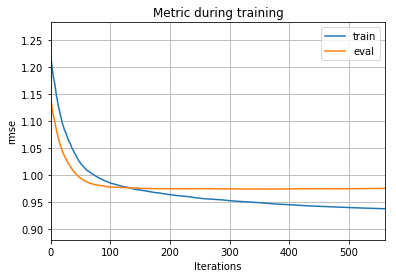

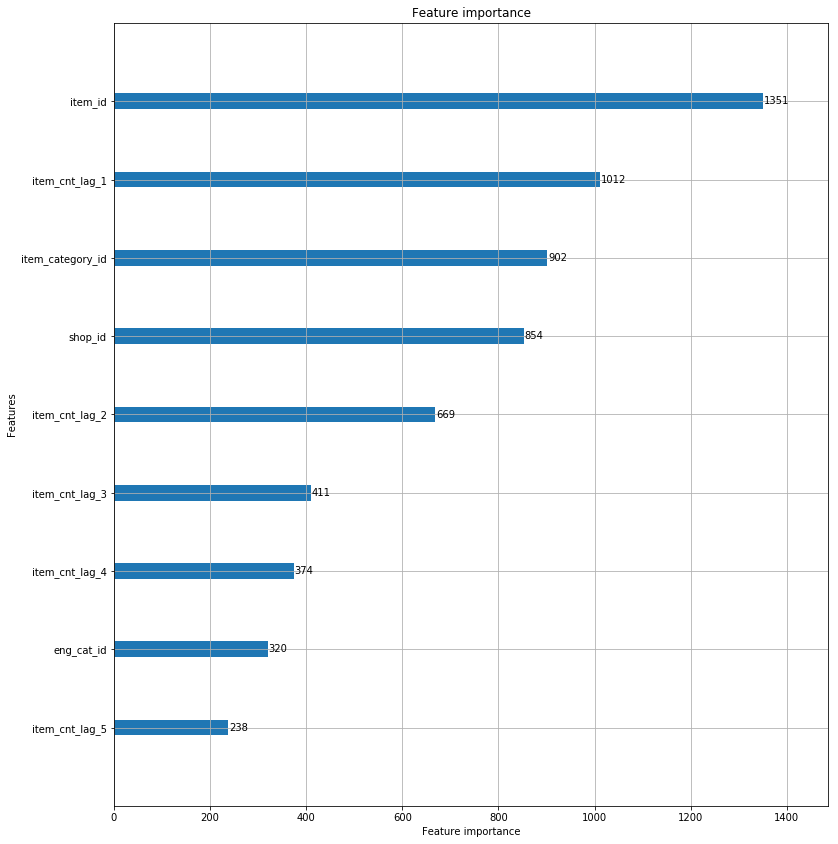

In [37]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
#plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_train.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

# Predict with test data¶

In [38]:
pred = ml.predict(model)

In [39]:
# Clip prediction to [0-20]
preds = np.clip(pred,0,20)

In [40]:
data['test'].shape

(214200, 3)

In [41]:
preds.shape

(214200,)

In [42]:
sub_df = pd.DataFrame({'ID':data['test'].ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.269571
std,61834.358168,0.671475
min,0.000000,0.000000
25%,53549.750000,0.080495
50%,107099.500000,0.112425
75%,160649.250000,0.219703
max,214199.000000,20.000000


In [43]:
pred_submit = pred

In [44]:
print pred.size
print pred
print 'Sum pred:',np.sum(pred)
# pred_submit = pred

# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit

214200
[0.32001393 0.18125926 0.88230192 ... 0.08291481 0.09311646 0.08836797]
Sum pred: 57707.86934964234
[0.32001393 0.18125926 0.88230192 ... 0.08291481 0.09311646 0.08836797]


total sales pred: 57742.09491011779 , mean: 0.269570937955732


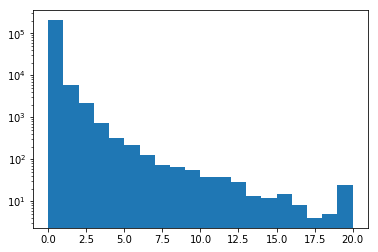

In [45]:
print 'total sales pred:',np.sum(pred_submit), ', mean:',np.mean(pred_submit)
hist_pred = plt.hist(pred_submit,bins=20,log=True)

In [46]:
sub_df.to_csv('Oct21-2018_1.csv',index=False)

# Validation with yearly trend

total sales count from Oct19-2018_3 prediction: 57742.09491011779
total sales count from contant 0.5 prediction: 107100.0


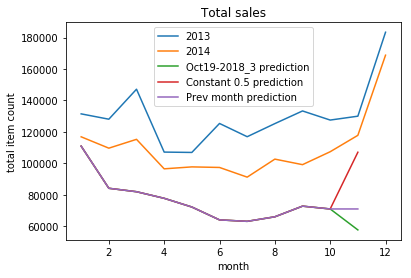

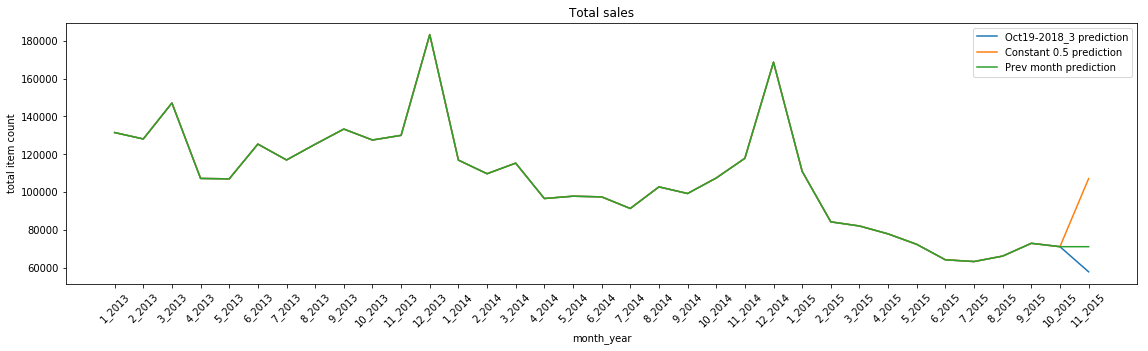

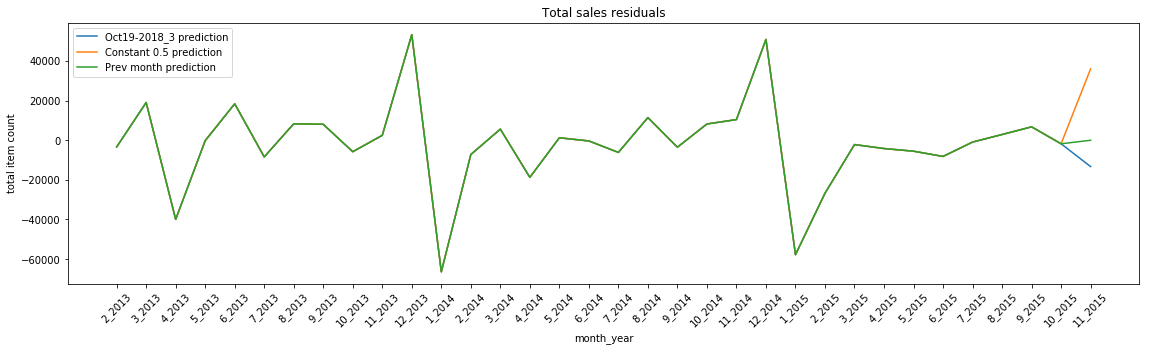

In [47]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
#saveName='constant_0p38'
#saveplots=True

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

# Analyse misprediction in validation

# Prepare submission file

In [48]:
# test_sorted = data['test'].sort_values(by=groupby_list).reset_index(drop=True)
# submit = pd.concat([test_sorted,y_test],axis=1)
# submit = submit.sort_values(by="ID").reset_index(drop=True)

# # sanity check
# print 'These numbers below should match:'
# print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
# print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

# submit = submit[["item_cnt_month"]]
# submit.index.name="ID"
# submit.head()

# submitName=''
# if submitName=='': 
#     submitName=saveName
# if(createSubmit):submit.to_csv('submit_'+submitName+'.csv')